<h1 style="text-align: center;">Human Pose Estimation Project</h1>
<h3 style="text-align: center;">By: Alazar Tegegnework</h3>

Human pose estimation is the idea of detecting keypoints of a human. This could be a 2d image of a perosn, a video, or even a 3d image. Keypoints in pose estimation tend to be human joints. Different pose estimation models identify different number of keypoints, ranging from 17 to over 100. My goal here today is to explore and implment a pose detection use case. 

Succesfull Pose Detection is a deep learning topic which we have not covered in this class for this reason I have focused on using a pretrained pose estimation model, MediaPipe Pose, to do the pose estimation keypoint ientification. I have then put images through this model to extract the keypoints of the person in the model. For this project I have focused on classifying a dance move in breakdancing. I have been interested in breakdanicng since I was a kid and I got the chnace to perform at a school talent show last year. I wished that there was some way to detemine if the "dance move" I was doing was correct. Due to this interest I have choosen to create a dataset of 2 different types of "poses" in break dancing. One is called a "Baby freeze" and another one is "windmill". In summary I have created a dataset for a 2 class-classification problem. 

In [93]:
# We first start by import basic libraries and also the mediapipe library for pose estimation
import mediapipe as mp
import pandas as pd
import math
import cv2
import autograd.numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from autograd import grad 

In [123]:
# importing and configuring the dataset. Data set was made using the data_gen.py file and and teh raw_images in the folder
csvname = '/Users/alazartegegnework/Documents/Year 3/EE375/Final Project/Data/Joint_angles.csv'
data = np.asarray(pd.read_csv(csvname, header = 0))
x = data[:,:-1].T
y = data[:,-1]
y.shape = (len(y),1)
# Encode string labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y.ravel())  # Flatten y before encoding
y_encoded = np.where(y_encoded == 0, -1, 1)  # Map classes to -1 and 1
y = y_encoded.reshape(-1,1).T  # Update y with numerical values

# Normalizing x
x_mean = np.mean(x)
x_std = np.std(x)
x_norm = (x - x_mean) / x_std

print(np.shape(x))
print(np.shape(y))

(8, 25)
(1, 25)


In [124]:
# Making training and testing data. 17/25 ~ 68% training and 8/25 ~ 32% testing data
indices = np.arange(25)
np.random.shuffle(indices)
Training = indices[:17]
x_training_set = x_norm.T[Training].T
y_training_set = y.T[Training].T

Validation = indices[17:]
x_validation_set = x_norm.T[Validation].T
y_validation_set = y.T[Validation].T

Here are all of the function I used to create my model. It relies on the fixed-shape family of universal approximators to learn the features of our data set.

In [125]:
def feature_transforms(x_pass, theta):
    # Generate transformed features
    f = np.vstack([x_pass**d for d in range(1, (theta.size // 8) + 1)])
    return f

def model(x_pass, theta):
    f = feature_transforms(x_pass, theta)
    a = np.dot(f.T, theta)
    return a.T

def gradient_descent(x_pass,y_pass,g,alpha,max_its,w):
    # compute gradient module using autograd
    gradient = grad(g, argnum=2)
    weight_history = [w]           # container for weight history
    cost_history = [g(x_pass,y_pass,w)]          # container for corresponding cost function history
    for k in range(max_its):
        # evaluate the gradient, store current weights and cost function value
        direction = gradient(x_pass,y_pass,w)
        # take gradient descent step
        w = w - (alpha * direction)
        # record weight and cost
        weight_history.append(w)
        cost_history.append(g(x_pass,y_pass,w))
    return weight_history,cost_history

def least_squares(x_pass,y_pass,w):
    cost = np.sum((model(x_pass,w) - y_pass)**2)
    return cost/(2*y_pass.size) # scaled to avoid overflow

def misclassifications(x, w):
    scores = model(x, w)
    # Apply a threshold for binary classification
    y_pred = np.where(scores >= 0, 1, -1)  # Adjust based on your label convention

    miss_class = np.sum(y_pred != y)

    return miss_class

In [126]:
g = least_squares 
max_its = 5000
alpha_choice = 0.01

training_error = []
validation_error = []
Total_misclassification = []
lowest_weights = []
min_val_error = 999
best_weights = 0
for m in range(1,6):
    w_0 = 1 * np.ones([8*m, 1])  # Match the total rows in f
    weight_history,cost_history = gradient_descent(x_training_set, y_training_set, g, alpha_choice, max_its, w_0)
    weights = weight_history[-1]
    lowest_weights.append(weights)
    training_error.append(cost_history[-1])

    validation_error.append(least_squares(x_validation_set, y_validation_set, weights))
    Total_misclassification.append(misclassifications(x_norm, weight_history[-1]))

    print(f"Number of misclassifications: {Total_misclassification[-1]}")

    if validation_error[-1] < min_val_error:
        min_val_error = validation_error[-1]
        best_weights = weights  # Store the best weights

np.savetxt("/Users/alazartegegnework/Documents/Year 3/EE375/Final Project/best_weights.csv", best_weights, delimiter=",")

Number of misclassifications: 3
Number of misclassifications: 2
Number of misclassifications: 2
Number of misclassifications: 1
Number of misclassifications: 2


Here are the plots of the total misclassification as well as the training and validation errors. We can primerly see that this is not a great model, primarily due to the low dataset used to train the model. We can see that first and second degree work best and then we quickly begin to overfit the model.

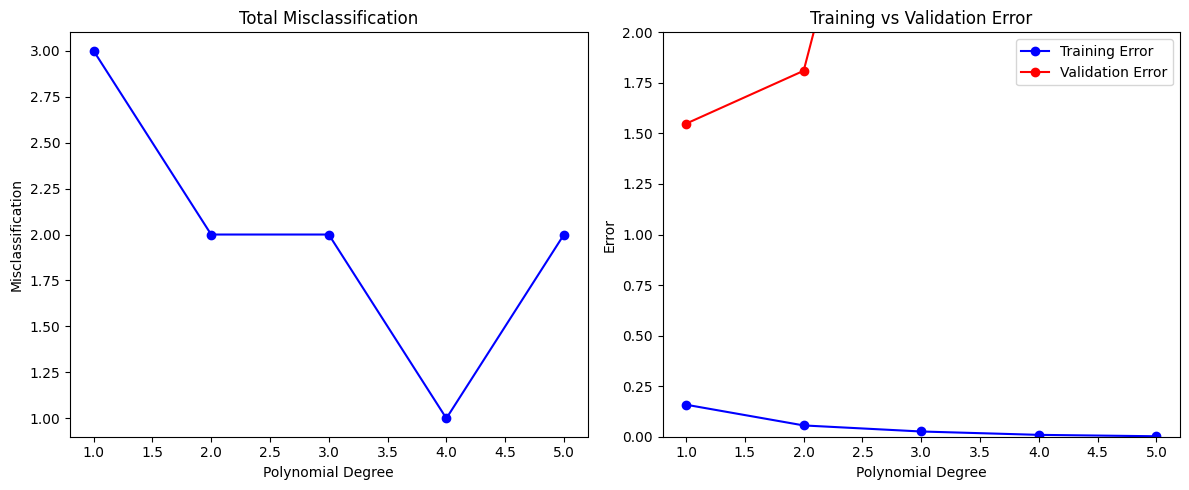

In [127]:
# Example data
polynomial_degrees = np.linspace(1, 5, 5)
# Subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot 1: Misclassification
axes[0].plot(np.linspace(1,5,5), Total_misclassification, '-ob')
axes[0].set_ylabel("Misclassification")
axes[0].set_xlabel("Polynomial Degree")
axes[0].set_title("Total Misclassification")

# Plot 2: Training and Validation Errors
axes[1].plot(np.linspace(1,5,5), training_error, '-ob', label="Training Error")
axes[1].plot(np.linspace(1,5,5), validation_error, '-or', label="Validation Error")
axes[1].set_ylabel("Error")
axes[1].set_xlabel("Polynomial Degree")
axes[1].set_ylim(0, 2)  # Adjust this based on your data range
axes[1].legend()
axes[1].set_title("Training vs Validation Error")

# Show the plots
plt.tight_layout()
plt.show()